# MIT License
Copyright (c) 2022 Karan Raman Agrawal, Sanika Patne

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Dataset Description
For this project we will be using the “UrbanSound8k” dataset, which is publicly available for academic use.

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The audio files are in ".wav" format. 

The samples are around 4 seconds in length. 

Each sound sample is labeled with the class to which it belongs. After downloading the dataset, we see that it consists of two parts:

- Audio files in the ‘audio’ folder: It has 10 sub-folders named ‘fold1’ through ‘fold10’. Each sub-folder contains a number of ‘.wav’ audio samples eg. ‘fold1/103074–7–1–0.wav’

- Metadata in the ‘metadata’ folder: It has a file ‘UrbanSound8K.csv’ that contains information about each audio sample in the dataset such as its filename, its class label, the ‘fold’ sub-folder location, and so on. The class label is a numeric Class ID from 0–9 for each of the 10 classes. eg. The number 0 means air conditioner, 1 is a car horn, and so on. 


In this evaluation, we will also be using Zero-Crossing Rate of Audio Waves along with the MFCC's and see if adding this feature was helped ML models to learn better

The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive. This Property would help ML models to classify noisy signals like - JackHammer, Drilling in a much efficient way

In [1]:
# Importing all necessary libraries for this execution
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [2]:
# Let's read a sample audio using librosa
audio_file_path = (
    r"C:\Users\Karan\Desktop\DSMT\Final-Project\UrbanSound8K\audio\fold2\4201-3-0-0.wav"
)
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [3]:
# Sample Check
print(librosa_audio_data)

[ 0.          0.          0.         ... -0.07455782 -0.07427226
  0.        ]


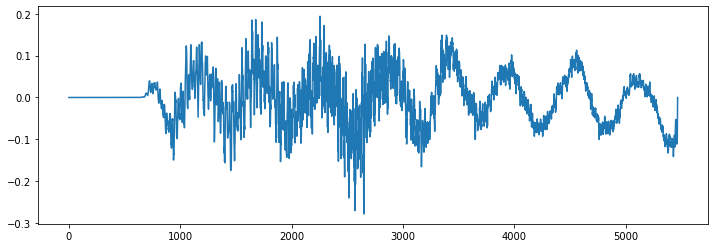

In [4]:
# Visual representation of uudio wave
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [5]:
# Reading audio wave and sampling rate
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [6]:
# Sample Check
wave_audio

array([[    0,     0],
       [    0,     0],
       [    0,     0],
       ...,
       [-2357, -2032],
       [-2327, -2161],
       [-2596, -2295]], dtype=int16)

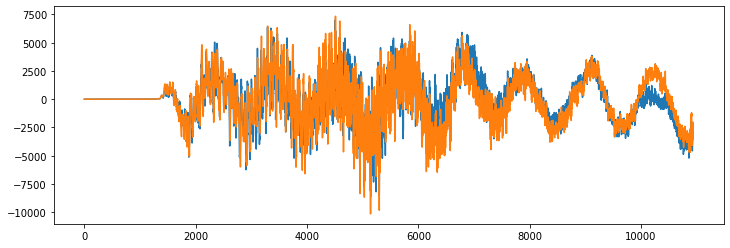

In [7]:
# Visual Representation of Audio
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

In [8]:
# Sample Check on Zero Crossing Rate extraction
zcr = librosa.feature.zero_crossing_rate(
    y=librosa_audio_data, frame_length=2048, hop_length=512, center=True
)
print(zcr.shape)

(1, 11)


In [9]:
# Reading Metadata of Audio Files
audio_dataset_path = r"C:\Users\Karan\Desktop\DSMT\Final-Project\UrbanSound8K\audio"
metadata = pd.read_csv(
    r"C:\Users\Karan\Desktop\DSMT\Final-Project\UrbanSound8K\metadata\UrbanSound8K.csv"
)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [10]:
# Function to extract MFCC's and Zero-Crossing rate of Audio Signals
def mfcc_features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")

    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    zcr_features = librosa.feature.zero_crossing_rate(
        y=audio, frame_length=2048, hop_length=512, center=True
    )
    zcr_features_scaled = np.mean(zcr_features.T, axis=0)

    features = mfccs_scaled_features + zcr_features_scaled

    return features

In [11]:
# Extraction of MFCC's and Zero Crossing Rate of all Audio Waves
mfcc_extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(
        os.path.abspath(audio_dataset_path),
        "fold" + str(row["fold"]) + "/",
        str(row["slice_file_name"]),
    )
    final_class_labels = row["class"]
    data = mfcc_features_extractor(file_name)
    mfcc_extracted_features.append([data, final_class_labels])

3555it [04:26, 17.54it/s]C:\Users\Karan\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8326it [09:00, 23.76it/s]C:\Users\Karan\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\Karan\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [09:24, 15.47it/s]


In [12]:
# Converting extracted_features to Pandas dataframe
mfcc_extracted_features_df = pd.DataFrame(
    mfcc_extracted_features, columns=["feature", "class"]
)
mfcc_extracted_features_df.head()

,feature,class
0,"[-218.0651092529297, 71.50975799560547, -131.3...",dog_bark
1,"[-424.9143375110075, 110.80895197873859, -54.0...",children_playing
2,"[-459.72476919538025, 122.93010751360414, -47....",children_playing
3,"[-414.6940469907198, 103.07604883447547, -36.5...",children_playing
4,"[-447.49011283389405, 115.20391792782469, -53....",children_playing


In [13]:
# Split the dataset into independent and dependent dataset
X = np.array(mfcc_extracted_features_df["feature"].tolist())
y = np.array(mfcc_extracted_features_df["class"].tolist())

In [14]:
# Shape of Independent Features
X.shape

(8732, 80)

In [15]:
# Shape of Dependent Features
y.shape

(8732,)

In [17]:
# One-Hot Encoding Dependent features to suit the use of Neural Networks
labelencoder = LabelEncoder()
labelencoder.fit(mfcc_extracted_features_df["class"])
labelencoder_name_mapping = dict(
    zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_))
)
y = to_categorical(labelencoder.fit_transform(y))

In [18]:
# Created a mapping dictionary of Label and category
labelencoder_name_mapping

{'air_conditioner': 0,
 'car_horn': 1,
 'children_playing': 2,
 'dog_bark': 3,
 'drilling': 4,
 'engine_idling': 5,
 'gun_shot': 6,
 'jackhammer': 7,
 'siren': 8,
 'street_music': 9}

In [19]:
# Data Spliting for Training and Validation Purpose
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
### No of classes
num_labels = y.shape[1]

In [21]:
# Building a deep neural network
dnn_model = Sequential()
###first layer with 800 neurons
dnn_model.add(Dense(800, input_shape=(80, X.shape[1])))
dnn_model.add(Activation("relu"))
dnn_model.add(Dropout(0.4))
###second layer with 400 neurons
dnn_model.add(Dense(400))
dnn_model.add(Activation("relu"))
dnn_model.add(Dropout(0.4))
###third layer with 200 neurons
dnn_model.add(Dense(200))
dnn_model.add(Activation("relu"))
dnn_model.add(Dropout(0.4))
###fourth layer with 100 neurons
dnn_model.add(Dense(100))
dnn_model.add(Activation("relu"))
dnn_model.add(Dropout(0.4))
###fifth layer with 50 neurons
dnn_model.add(Dense(50))
dnn_model.add(Activation("relu"))
dnn_model.add(Dropout(0.4))
###final layer with 10 neurons which is number of classes
dnn_model.add(Dense(num_labels))
dnn_model.add(Activation("softmax"))

In [22]:
# Building a LSTM
lstm_model = Sequential()
# First Layer with 80 LSTM units
lstm_model.add(
    LSTM(80, dropout=0.2, return_sequences=True, input_shape=(X.shape[1], 1))
)
# Second Layer with 80 LSTM units
lstm_model.add(LSTM(80, dropout=0.2))
# Third layer of 80 Normal Neurons
lstm_model.add(Dense(80, activation="relu"))
lstm_model.add(Dropout(0.15))
# Third layer of 40 Normal Neurons
lstm_model.add(Dense(40, activation="relu"))
lstm_model.add(Dropout(0.15))
# Third layer of 20 Normal Neurons
lstm_model.add(Dense(20, activation="relu"))
lstm_model.add(Dropout(0.15))
# Third layer of 10 Normal Neurons
lstm_model.add(Dense(num_labels, activation="softmax"))

In [23]:
# Summary of Deep Neural Network
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80, 800)           64800     
                                                                 
 activation (Activation)     (None, 80, 800)           0         
                                                                 
 dropout (Dropout)           (None, 80, 800)           0         
                                                                 
 dense_1 (Dense)             (None, 80, 400)           320400    
                                                                 
 activation_1 (Activation)   (None, 80, 400)           0         
                                                                 
 dropout_1 (Dropout)         (None, 80, 400)           0         
                                                                 
 dense_2 (Dense)             (None, 80, 200)           8

In [24]:
# Summary of LSTM
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 80)            26240     
                                                                 
 lstm_1 (LSTM)               (None, 80)                51520     
                                                                 
 dense_6 (Dense)             (None, 80)                6480      
                                                                 
 dropout_5 (Dropout)         (None, 80)                0         
                                                                 
 dense_7 (Dense)             (None, 40)                3240      
                                                                 
 dropout_6 (Dropout)         (None, 40)                0         
                                                                 
 dense_8 (Dense)             (None, 20)               

In [25]:
# Custom Definations to extract evaluation metrics like Recall, Precision and F1 Score
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [26]:
# Compiling Deep Model
dnn_model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy", f1_m, precision_m, recall_m],
    optimizer="adam",
)

In [27]:
# Compiling LSTM model
lstm_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", f1_m, precision_m, recall_m],
)

In [28]:
# Training a Deep Neural Network, and Saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 128

checkpointer = ModelCheckpoint(
    filepath="saved_models/zcr_dnn_audio_classification.h5",
    verbose=1,
    save_best_only=True,
)
start = datetime.now()

dnn_history = dnn_model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
    callbacks=[checkpointer],
    verbose=1,
)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
49/55 [=========================>....] - ETA: 0s - loss: 5.1434 - accuracy: 0.1048 - f1_m: 0.0510 - precision_m: 0.1082 - recall_m: 0.0392WARNING:tensorflow:Model was constructed with shape (None, 80, 80) for input KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80), dtype=tf.float32, name='dense_input'), name='dense_input', description="created by layer 'dense_input'"), but it was called on an input with incompatible shape (None, 80).

Epoch 1: val_loss improved from inf to 2.28521, saving model to saved_models\zcr_dnn_audio_classification.h5
55/55 [==============================] - 1s 13ms/step - loss: 4.8704 - accuracy: 0.1061 - f1_m: 0.0465 - precision_m: 0.1131 - recall_m: 0.0355 - val_loss: 2.2852 - val_accuracy: 0.1471 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
53/55 [===========================>..] - ETA: 0s - loss: 2.3762 - accuracy: 0.1144 - f1_m: 0.0052 - precision_m: 0.1142 - recall_m: 0.0027  
Epoch 2: val_loss

Epoch 15/100
49/55 [=========================>....] - ETA: 0s - loss: 1.5722 - accuracy: 0.4479 - f1_m: 0.3639 - precision_m: 0.7843 - recall_m: 0.2380
Epoch 15: val_loss improved from 1.45862 to 1.33953, saving model to saved_models\zcr_dnn_audio_classification.h5
55/55 [==============================] - 1s 9ms/step - loss: 1.5639 - accuracy: 0.4480 - f1_m: 0.3698 - precision_m: 0.7876 - recall_m: 0.2428 - val_loss: 1.3395 - val_accuracy: 0.5621 - val_f1_m: 0.4658 - val_precision_m: 0.9173 - val_recall_m: 0.3133
Epoch 16/100
55/55 [==============================] - ETA: 0s - loss: 1.5022 - accuracy: 0.4776 - f1_m: 0.4001 - precision_m: 0.8081 - recall_m: 0.2669
Epoch 16: val_loss improved from 1.33953 to 1.25743, saving model to saved_models\zcr_dnn_audio_classification.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5022 - accuracy: 0.4776 - f1_m: 0.4001 - precision_m: 0.8081 - recall_m: 0.2669 - val_loss: 1.2574 - val_accuracy: 0.6108 - val_f1_m: 0.4898 - val_preci

Epoch 31/100
51/55 [==========================>...] - ETA: 0s - loss: 0.8463 - accuracy: 0.7258 - f1_m: 0.6972 - precision_m: 0.8949 - recall_m: 0.5722
Epoch 31: val_loss improved from 0.72993 to 0.70834, saving model to saved_models\zcr_dnn_audio_classification.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.8497 - accuracy: 0.7260 - f1_m: 0.6961 - precision_m: 0.8932 - recall_m: 0.5715 - val_loss: 0.7083 - val_accuracy: 0.7831 - val_f1_m: 0.7383 - val_precision_m: 0.9489 - val_recall_m: 0.6059
Epoch 32/100
53/55 [===========================>..] - ETA: 0s - loss: 0.8286 - accuracy: 0.7344 - f1_m: 0.7110 - precision_m: 0.9009 - recall_m: 0.5881
Epoch 32: val_loss did not improve from 0.70834
55/55 [==============================] - 0s 7ms/step - loss: 0.8279 - accuracy: 0.7347 - f1_m: 0.7107 - precision_m: 0.9007 - recall_m: 0.5877 - val_loss: 0.7210 - val_accuracy: 0.7790 - val_f1_m: 0.7464 - val_precision_m: 0.9439 - val_recall_m: 0.6188
Epoch 33/100
55/55 [========

Epoch 48/100
49/55 [=========================>....] - ETA: 0s - loss: 0.5229 - accuracy: 0.8356 - f1_m: 0.8320 - precision_m: 0.9116 - recall_m: 0.7658
Epoch 48: val_loss improved from 0.49509 to 0.49260, saving model to saved_models\zcr_dnn_audio_classification.h5
55/55 [==============================] - 0s 9ms/step - loss: 0.5247 - accuracy: 0.8345 - f1_m: 0.8311 - precision_m: 0.9113 - recall_m: 0.7644 - val_loss: 0.4926 - val_accuracy: 0.8569 - val_f1_m: 0.8654 - val_precision_m: 0.9190 - val_recall_m: 0.8179
Epoch 49/100
48/55 [=========================>....] - ETA: 0s - loss: 0.5378 - accuracy: 0.8341 - f1_m: 0.8316 - precision_m: 0.9096 - recall_m: 0.7664
Epoch 49: val_loss improved from 0.49260 to 0.45641, saving model to saved_models\zcr_dnn_audio_classification.h5
55/55 [==============================] - 0s 9ms/step - loss: 0.5342 - accuracy: 0.8346 - f1_m: 0.8321 - precision_m: 0.9101 - recall_m: 0.7670 - val_loss: 0.4564 - val_accuracy: 0.8678 - val_f1_m: 0.8711 - val_preci

Epoch 65/100
55/55 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8826 - f1_m: 0.8819 - precision_m: 0.9310 - recall_m: 0.8382
Epoch 65: val_loss did not improve from 0.35791
55/55 [==============================] - 1s 10ms/step - loss: 0.3870 - accuracy: 0.8826 - f1_m: 0.8819 - precision_m: 0.9310 - recall_m: 0.8382 - val_loss: 0.4090 - val_accuracy: 0.8855 - val_f1_m: 0.8893 - val_precision_m: 0.9185 - val_recall_m: 0.8620
Epoch 66/100
51/55 [==========================>...] - ETA: 0s - loss: 0.3816 - accuracy: 0.8822 - f1_m: 0.8843 - precision_m: 0.9307 - recall_m: 0.8425
Epoch 66: val_loss did not improve from 0.35791
55/55 [==============================] - 1s 11ms/step - loss: 0.3812 - accuracy: 0.8835 - f1_m: 0.8858 - precision_m: 0.9311 - recall_m: 0.8451 - val_loss: 0.3912 - val_accuracy: 0.8901 - val_f1_m: 0.8923 - val_precision_m: 0.9217 - val_recall_m: 0.8649
Epoch 67/100
51/55 [==========================>...] - ETA: 0s - loss: 0.3596 - accuracy: 0.8

Epoch 83/100
49/55 [=========================>....] - ETA: 0s - loss: 0.2690 - accuracy: 0.9163 - f1_m: 0.9204 - precision_m: 0.9509 - recall_m: 0.8919
Epoch 83: val_loss did not improve from 0.33006
55/55 [==============================] - 1s 10ms/step - loss: 0.2825 - accuracy: 0.9150 - f1_m: 0.9185 - precision_m: 0.9492 - recall_m: 0.8899 - val_loss: 0.3435 - val_accuracy: 0.9084 - val_f1_m: 0.9081 - val_precision_m: 0.9359 - val_recall_m: 0.8822
Epoch 84/100
52/55 [===========================>..] - ETA: 0s - loss: 0.2876 - accuracy: 0.9145 - f1_m: 0.9144 - precision_m: 0.9473 - recall_m: 0.8840
Epoch 84: val_loss did not improve from 0.33006
55/55 [==============================] - 1s 10ms/step - loss: 0.2869 - accuracy: 0.9147 - f1_m: 0.9150 - precision_m: 0.9482 - recall_m: 0.8844 - val_loss: 0.3333 - val_accuracy: 0.9130 - val_f1_m: 0.9135 - val_precision_m: 0.9406 - val_recall_m: 0.8881
Epoch 85/100
52/55 [===========================>..] - ETA: 0s - loss: 0.2779 - accuracy: 0.9

Training completed in time:  0:00:50.883325


In [29]:
# Training the LSTM Neural Network, and Saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 128

checkpointer = ModelCheckpoint(
    filepath="saved_models/zcr_lstm_audio_classification.h5",
    verbose=1,
    save_best_only=True,
)
start = datetime.now()

lstm_history = lstm_model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
    callbacks=[checkpointer],
    verbose=1,
)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 2.2335 - accuracy: 0.1572 - f1_m: 8.4567e-04 - precision_m: 0.0545 - recall_m: 4.2614e-04
Epoch 1: val_loss improved from inf to 2.10761, saving model to saved_models\zcr_lstm_audio_classification.h5
55/55 [==============================] - 14s 193ms/step - loss: 2.2335 - accuracy: 0.1572 - f1_m: 8.4567e-04 - precision_m: 0.0545 - recall_m: 4.2614e-04 - val_loss: 2.1076 - val_accuracy: 0.2290 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 2.0583 - accuracy: 0.2226 - f1_m: 0.0237 - precision_m: 0.5389 - recall_m: 0.0123
Epoch 2: val_loss improved from 2.10761 to 1.98348, saving model to saved_models\zcr_lstm_audio_classification.h5
55/55 [==============================] - 10s 178ms/step - loss: 2.0583 - accuracy: 0.2226 - f1_m: 0.0237 - precision_m: 0.5389 - recall_m: 0.0123 - val_loss: 1.9835 - val_accuracy: 0.2662 - 

Epoch 17/100
55/55 [==============================] - ETA: 0s - loss: 1.3687 - accuracy: 0.5351 - f1_m: 0.4320 - precision_m: 0.7168 - recall_m: 0.3103
Epoch 17: val_loss improved from 1.27856 to 1.26224, saving model to saved_models\zcr_lstm_audio_classification.h5
55/55 [==============================] - 9s 164ms/step - loss: 1.3687 - accuracy: 0.5351 - f1_m: 0.4320 - precision_m: 0.7168 - recall_m: 0.3103 - val_loss: 1.2622 - val_accuracy: 0.5655 - val_f1_m: 0.4930 - val_precision_m: 0.7777 - val_recall_m: 0.3626
Epoch 18/100
55/55 [==============================] - ETA: 0s - loss: 1.3572 - accuracy: 0.5412 - f1_m: 0.4451 - precision_m: 0.7100 - recall_m: 0.3249
Epoch 18: val_loss improved from 1.26224 to 1.20476, saving model to saved_models\zcr_lstm_audio_classification.h5
55/55 [==============================] - 9s 156ms/step - loss: 1.3572 - accuracy: 0.5412 - f1_m: 0.4451 - precision_m: 0.7100 - recall_m: 0.3249 - val_loss: 1.2048 - val_accuracy: 0.5879 - val_f1_m: 0.5277 - val

Epoch 34/100
55/55 [==============================] - ETA: 0s - loss: 1.0479 - accuracy: 0.6576 - f1_m: 0.6181 - precision_m: 0.7928 - recall_m: 0.5072
Epoch 34: val_loss did not improve from 1.04137
55/55 [==============================] - 8s 151ms/step - loss: 1.0479 - accuracy: 0.6576 - f1_m: 0.6181 - precision_m: 0.7928 - recall_m: 0.5072 - val_loss: 1.0912 - val_accuracy: 0.6394 - val_f1_m: 0.6222 - val_precision_m: 0.7560 - val_recall_m: 0.5296
Epoch 35/100
55/55 [==============================] - ETA: 0s - loss: 1.0411 - accuracy: 0.6620 - f1_m: 0.6221 - precision_m: 0.7872 - recall_m: 0.5152
Epoch 35: val_loss improved from 1.04137 to 1.01620, saving model to saved_models\zcr_lstm_audio_classification.h5
55/55 [==============================] - 9s 156ms/step - loss: 1.0411 - accuracy: 0.6620 - f1_m: 0.6221 - precision_m: 0.7872 - recall_m: 0.5152 - val_loss: 1.0162 - val_accuracy: 0.6663 - val_f1_m: 0.6456 - val_precision_m: 0.7905 - val_recall_m: 0.5471
Epoch 36/100
55/55 [===

Epoch 69/100
55/55 [==============================] - ETA: 0s - loss: 0.7659 - accuracy: 0.7529 - f1_m: 0.7407 - precision_m: 0.8450 - recall_m: 0.6601
Epoch 69: val_loss did not improve from 0.82482
55/55 [==============================] - 9s 161ms/step - loss: 0.7659 - accuracy: 0.7529 - f1_m: 0.7407 - precision_m: 0.8450 - recall_m: 0.6601 - val_loss: 0.8422 - val_accuracy: 0.7350 - val_f1_m: 0.7298 - val_precision_m: 0.8152 - val_recall_m: 0.6619
Epoch 70/100
55/55 [==============================] - ETA: 0s - loss: 0.7670 - accuracy: 0.7545 - f1_m: 0.7422 - precision_m: 0.8433 - recall_m: 0.6633
Epoch 70: val_loss did not improve from 0.82482
55/55 [==============================] - 9s 159ms/step - loss: 0.7670 - accuracy: 0.7545 - f1_m: 0.7422 - precision_m: 0.8433 - recall_m: 0.6633 - val_loss: 0.9282 - val_accuracy: 0.7115 - val_f1_m: 0.6998 - val_precision_m: 0.7890 - val_recall_m: 0.6291
Epoch 71/100
55/55 [==============================] - ETA: 0s - loss: 0.7566 - accuracy: 0

Epoch 87/100
55/55 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.7843 - f1_m: 0.7725 - precision_m: 0.8575 - recall_m: 0.7034
Epoch 87: val_loss did not improve from 0.77140
55/55 [==============================] - 9s 158ms/step - loss: 0.6704 - accuracy: 0.7843 - f1_m: 0.7725 - precision_m: 0.8575 - recall_m: 0.7034 - val_loss: 0.8016 - val_accuracy: 0.7430 - val_f1_m: 0.7502 - val_precision_m: 0.8143 - val_recall_m: 0.6959
Epoch 88/100
55/55 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.7805 - f1_m: 0.7731 - precision_m: 0.8582 - recall_m: 0.7038
Epoch 88: val_loss did not improve from 0.77140
55/55 [==============================] - 9s 158ms/step - loss: 0.6705 - accuracy: 0.7805 - f1_m: 0.7731 - precision_m: 0.8582 - recall_m: 0.7038 - val_loss: 0.8614 - val_accuracy: 0.7418 - val_f1_m: 0.7367 - val_precision_m: 0.8071 - val_recall_m: 0.6785
Epoch 89/100
55/55 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0

In [30]:
# Evaluating DNN Model on test (unseen) data
test_accuracy = dnn_model.evaluate(X_test, y_test, verbose=0)
print("Loss of the model is = " + str(test_accuracy[0]))
print("Accuracy of the model on testing data is = " + str(test_accuracy[1]))
print("F1 Score of the model is = " + str(test_accuracy[2]))
print("Precision of the model is = " + str(test_accuracy[3]))
print("Recall of the model is = " + str(test_accuracy[4]))

Loss of the model is = 0.32051876187324524
Accuracy of the model on testing data is = 0.9129937291145325
F1 Score of the model is = 0.9130880832672119
Precision of the model is = 0.9359825253486633
Recall of the model is = 0.8923743963241577


In [31]:
# Evaluating LSTM Model on test (unseen) data
test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print("Loss of the model is = " + str(test_accuracy[0]))
print("Accuracy of the model on testing data is = " + str(test_accuracy[1]))
print("F1 Score of the model is = " + str(test_accuracy[2]))
print("Precision of the model is = " + str(test_accuracy[3]))
print("Recall of the model is = " + str(test_accuracy[4]))

Loss of the model is = 0.8248026967048645
Accuracy of the model on testing data is = 0.7487120628356934
F1 Score of the model is = 0.7459818720817566
Precision of the model is = 0.8110241293907166
Recall of the model is = 0.6923145651817322


In [32]:
def plot_performance(data):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # summarize history for accuracy
    ax[0].plot(data.history["accuracy"])
    ax[0].plot(data.history["val_accuracy"])
    ax[0].set_title("model accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(["train", "test"], loc="upper left")

    # summarize history for loss
    ax[1].plot(data.history["loss"], label=["loss"])
    ax[1].plot(data.history["val_loss"], label=["val_loss"])
    ax[1].set_title("model loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend(["train", "test"], loc="upper left")
    plt.show()

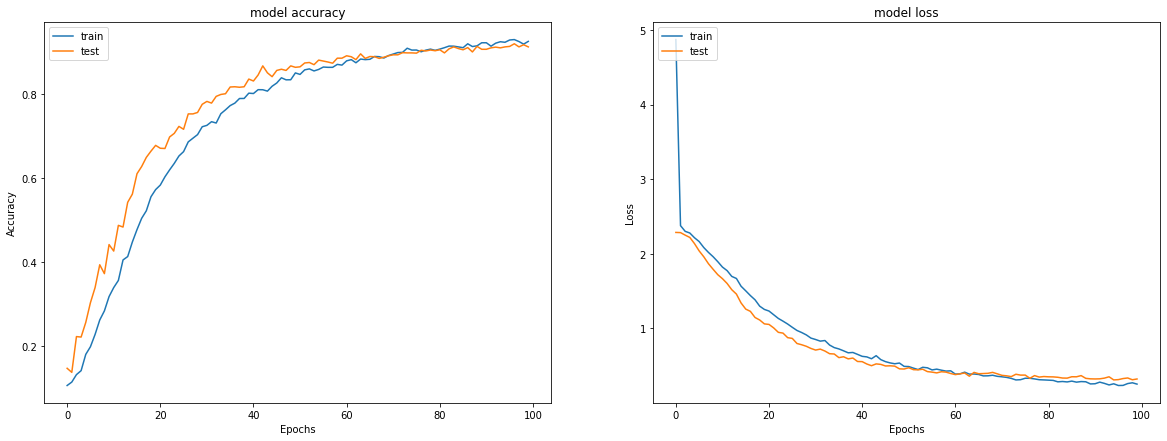

In [33]:
# Performance (Accuracy and Loss) of DNN during the training
plot_performance(dnn_history)

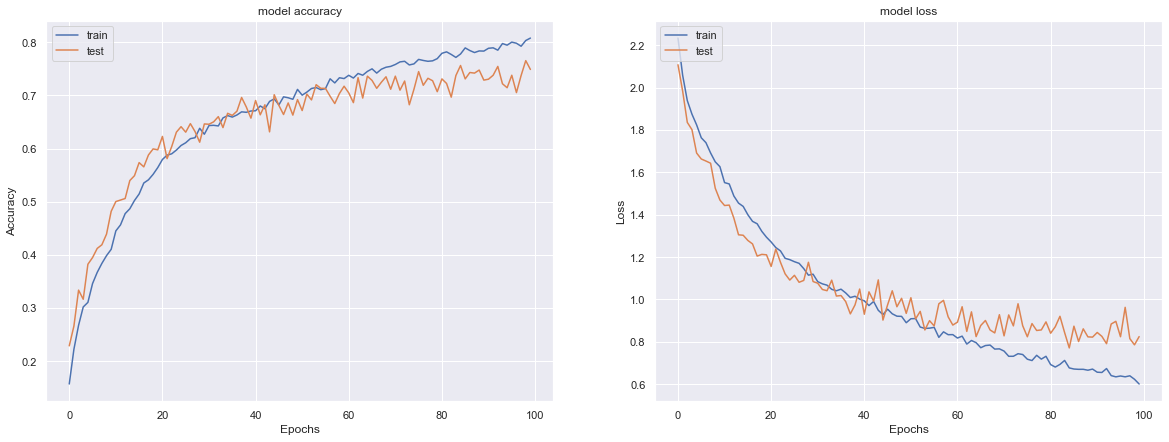

In [44]:
# Performance (Accuracy and Loss) of LSTM during the training
plot_performance(lstm_history)

In [34]:
# Making Predictions on Test data
dnn_predictions = dnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

In [35]:
# Mapping the output with actual label
dnn_predictions = np.argmax(dnn_predictions, axis=1)
lstm_predictions = np.argmax(lstm_predictions, axis=1)
y_test = np.argmax(y_test, axis=1)

In [36]:
def get_key(val):
    for key, value in labelencoder_name_mapping.items():
        if val == value:
            return key


def mapping(predictions):
    new_list = []
    for i in predictions:
        new_list.append(get_key(i))
    return np.array(new_list)

In [37]:
dnn_predictions = mapping(dnn_predictions)
lstm_predictions = mapping(lstm_predictions)
y_test = mapping(y_test)

In [38]:
class_names = np.unique(dnn_predictions)
class_names

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype='<U16')

In [39]:
import seaborn as sns
from sklearn.metrics import *

sns.set(rc={"figure.figsize": (11.7, 8.27)})
dnn_matrix = confusion_matrix(y_test, dnn_predictions, labels=class_names)
lstm_matrix = confusion_matrix(y_test, lstm_predictions, labels=class_names)

In [40]:
dnn_cmtx = pd.DataFrame(
    dnn_matrix,
    index=["true:{:}".format(x) for x in class_names],
    columns=["pred:{:}".format(x) for x in class_names],
)

lstm_cmtx = pd.DataFrame(
    lstm_matrix,
    index=["true:{:}".format(x) for x in class_names],
    columns=["pred:{:}".format(x) for x in class_names],
)

<AxesSubplot:>

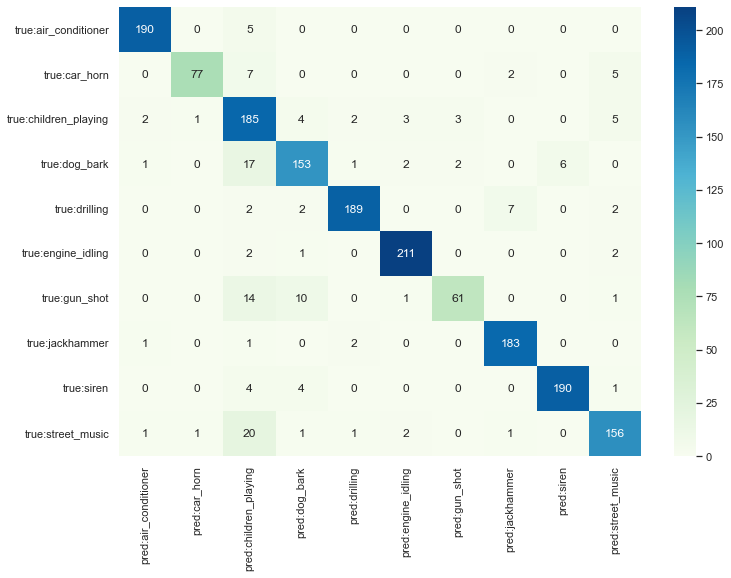

In [41]:
# Confusion Matrix for the Deep Learning Model, Features - MFCC's and Zero Crossing
sns.heatmap(dnn_cmtx, annot=True, cmap="GnBu", fmt="g")

<AxesSubplot:>

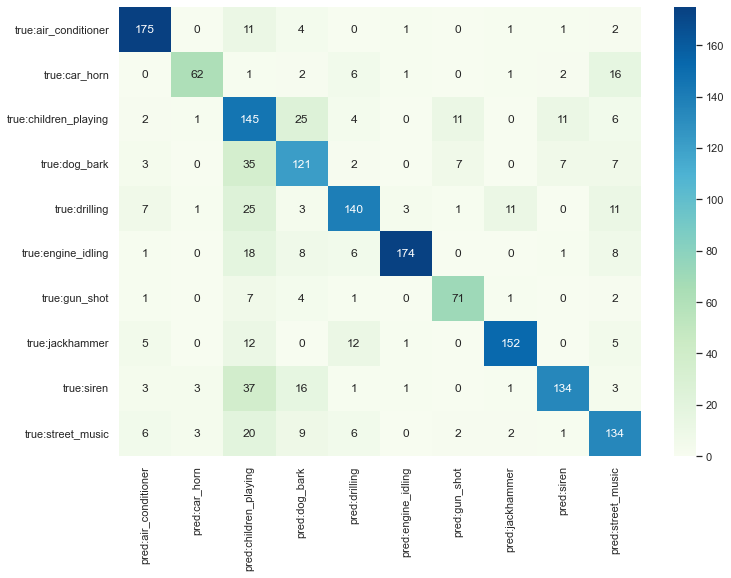

In [42]:
# Confusion Matrix for the LSTM Model, Features - MFCC's and Zero Crossing rate
sns.heatmap(lstm_cmtx, annot=True, cmap="GnBu", fmt="g")